# データ取得

In [1]:
import tcx2df

path_tcx_file = 'data/hiking_1.tcx'

In [2]:
 #originalの表示→元のファイルを開いたらいいんじゃないか
with open(path_tcx_file) as f:
        lines = f.readlines()
lines

['\ufeff<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n',
 '<TrainingCenterDatabase xmlns="http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2">\n',
 '    <Activities>\n',
 '        <Activity Sport="Other">\n',
 '            <Id>2018-05-21T06:16:57.000+09:00</Id>\n',
 '            <Lap StartTime="2018-05-21T06:16:57.000+09:00">\n',
 '                <TotalTimeSeconds>8391.0</TotalTimeSeconds>\n',
 '                <DistanceMeters>11953.780000000002</DistanceMeters>\n',
 '                <Calories>1101</Calories>\n',
 '                <Intensity>Active</Intensity>\n',
 '                <TriggerMethod>Manual</TriggerMethod>\n',
 '                <Track>\n',
 '                    <Trackpoint>\n',
 '                        <Time>2018-05-21T06:16:57.000+09:00</Time>\n',
 '                        <Position>\n',
 '                            <LatitudeDegrees>34.80131995677948</LatitudeDegrees>\n',
 '                            <LongitudeDegrees>135.69762325286865</LongitudeDe

In [3]:
#tcxファイルに対する前処理と読み込み
xml_data = tcx2df.tcx_file_convert(path_tcx_file)
df = tcx2df.xml2df(xml_data)
df = tcx2df.pp_data(df)

In [4]:
df['Time'] = df['Time'].dt.time

In [5]:
df.head()

,Time,Latitude,Longitude,Altitude,Distance,HeartRate
0,06:16:57,34.801320,135.697623,49.740800,0.00,104.0
1,06:16:58,34.801343,135.697620,49.297876,0.00,104.0
2,06:16:59,34.801360,135.697620,48.925575,0.00,105.0
3,06:17:00,34.801367,135.697620,48.551724,1.66,106.0
4,06:17:01,34.801383,135.697620,48.367975,2.86,106.0


# 描画

In [6]:
import folium

# 地図オブジェクトを作成
m = folium.Map(location=[df["Latitude"].min(), df["Longitude"].min()], zoom_start=13)
df_lat_lon = df[['Latitude', 'Longitude']]
locs = df_lat_lon.values
folium.PolyLine(locs,color='red').add_to(m)
m

# EDA

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

In [8]:
#1秒あたりの移動距離を算出
df['Distance_before'] = list(pd.concat([pd.Series([0]),df['Distance'][:-1]]))
df['speed'] = df['Distance'] - df['Distance_before']
df['speed'] = df['speed'].apply(lambda x:0 if x<0 else x)

#1秒あたりの高低差を算出
df['Altitude_before'] = list(pd.concat([pd.Series([0]),df['Altitude'][:-1]]))
df['diff_altitude'] = df['Altitude'] - df['Altitude_before']
df.loc[0, 'diff_altitude'] = 0

#1秒あたりの勾配を算出
df['slope'] = df['diff_altitude'] / df['speed']

df = df.drop(['Distance_before', 'Altitude_before'], axis=1)

In [9]:
df.head()

,Time,Latitude,Longitude,Altitude,Distance,HeartRate,speed,diff_altitude,slope
0,06:16:57,34.801320,135.697623,49.740800,0.00,104.0,0.00,0.000000,NaN
1,06:16:58,34.801343,135.697620,49.297876,0.00,104.0,0.00,-0.442924,-inf
2,06:16:59,34.801360,135.697620,48.925575,0.00,105.0,0.00,-0.372301,-inf
3,06:17:00,34.801367,135.697620,48.551724,1.66,106.0,1.66,-0.373851,-0.225211
4,06:17:01,34.801383,135.697620,48.367975,2.86,106.0,1.20,-0.183749,-0.153124


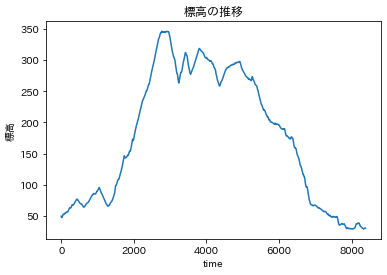

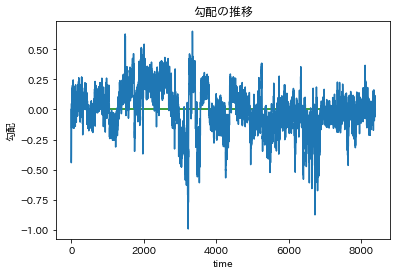

In [10]:
plt.plot(df['Altitude'])
plt.title('標高の推移')
plt.xlabel('time')
plt.ylabel('標高')
plt.show()

plt.plot(df['diff_altitude'])
plt.hlines(0, -10, 8000, color='green', linestyle='-')
plt.title('勾配の推移')
plt.xlabel('time')
plt.ylabel('勾配')
plt.show()

+ 登りは緩やかだが、下りは急だったことがわかる

In [23]:
df_tmp = df[['elapsed_time', 'HeartRate', 'speed', 'slope']]
df_tmp

,elapsed_time,HeartRate,speed,slope
0,0,104.0,0.00,NaN
1,1,104.0,0.00,-inf
2,2,105.0,0.00,-inf
3,3,106.0,1.66,-0.225211
4,4,106.0,1.20,-0.153124
...,...,...,...,...
8378,8378,107.0,0.00,inf
8379,8379,107.0,0.00,inf
8380,8380,107.0,0.00,NaN
8381,8381,107.0,0.00,NaN


In [27]:
df_corr = df_tmp.corr()
df_corr

,elapsed_time,HeartRate,speed,slope
elapsed_time,1.000000,-0.351045,0.140661,-0.257679
HeartRate,-0.351045,1.000000,-0.118118,0.318416
speed,0.140661,-0.118118,1.000000,-0.162699
slope,-0.257679,0.318416,-0.162699,1.000000


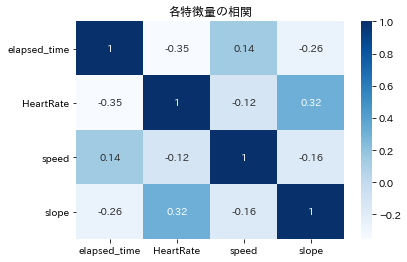

In [32]:
import seaborn as sns

sns.heatmap(df_corr, annot=True, cmap='Blues')
plt.title('各特徴量の相関')
plt.show()

In [11]:
df['HeartRate_10'] = df['HeartRate'].rolling(10).mean()
df['speed_10'] = df['speed'].rolling(10).mean()
df['slope_10'] = df['slope'].rolling(10).mean()
df['elapsed_time']  = df.index

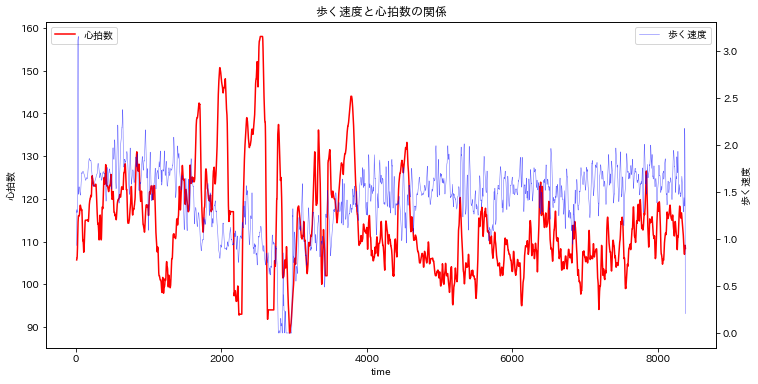

In [34]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(df['HeartRate_10'], color='red', label='心拍数')
ax.set_title('歩く速度と心拍数の関係')
ax.set_ylabel('心拍数')
ax.set_xlabel('time')


ax2 = ax.twinx()
ax2.plot(df['speed_10'], color='blue', alpha=0.6, linewidth=0.5, label='歩く速度')
ax2.set_ylabel('歩く速度')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

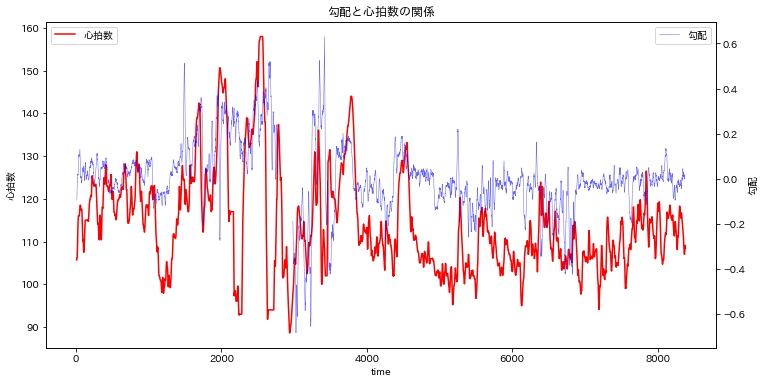

In [33]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(df['HeartRate_10'], color='red', label='心拍数')
ax.set_title('勾配と心拍数の関係')
ax.set_ylabel('心拍数')
ax.set_xlabel('time')

ax2 = ax.twinx()
ax2.plot(df['slope_10'], color='blue', alpha=0.6, linewidth=0.5, label='勾配')
ax2.set_ylabel('勾配')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

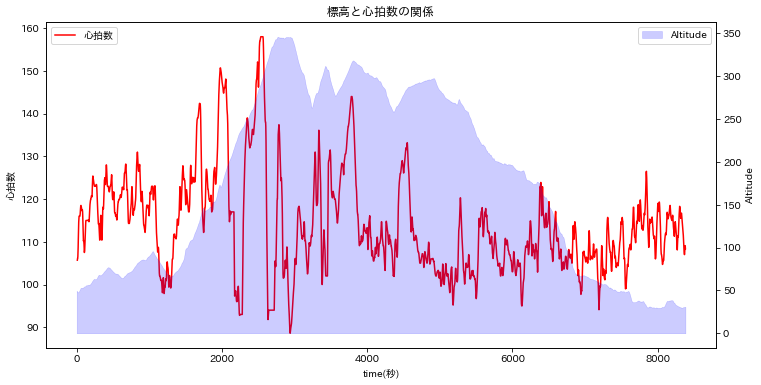

In [40]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(df['HeartRate_10'], color='red', label='心拍数')
ax.set_title('標高と心拍数の関係')
ax.set_ylabel('心拍数')
ax.set_xlabel('time(秒)')


ax2 = ax.twinx()
ax2.fill_between(df['elapsed_time'], df['Altitude'], color='blue', alpha=0.2, linewidth=0.5, label='Altitude')
ax2.set_ylabel('Altitude')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

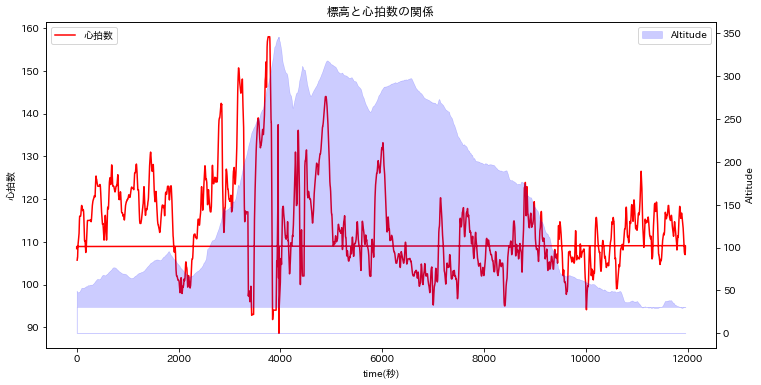

In [41]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.plot(df['Distance'], df['HeartRate_10'], color='red', label='心拍数')
ax.set_title('標高と心拍数の関係')
ax.set_ylabel('心拍数')
ax.set_xlabel('time(秒)')


ax2 = ax.twinx()
ax2.fill_between(df['Distance'], df['Altitude'], color='blue', alpha=0.2, linewidth=0.5, label='Altitude')
ax2.set_ylabel('Altitude')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()